In [1]:
!pip install geopandas
!pip install rtree

In [2]:
import pandas as pd
import numpy as np
import folium # map rendering library
from sklearn.cluster import KMeans # import k-means from clustering stage
import requests
from urllib.request import urlopen
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import math
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA 
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sms
from geopandas import GeoDataFrame
import geopandas as gpd

# Preprocessing LSOA Region Data

#### Load Data

In [3]:
df_losa1 = pd.read_excel('https://data.london.gov.uk/download/lsoa-atlas/b8e01c3a-f5e3-4417-82b3-02ad271e6ee8/lsoa-data.xls',
                         sheet_name='iadatasheet1',
                         header=[0,1,2])

In [4]:
df_losa2 = pd.read_excel('https://data.london.gov.uk/download/lsoa-atlas/b8e01c3a-f5e3-4417-82b3-02ad271e6ee8/lsoa-data.xls', 
                          sheet_name='iadatasheet2',
                          header=[0,1,2])            

#### Data Cleansing

In [5]:
df_losa1.head(3)

Unnamed: 0_level_0 Unnamed: 1_level_0 Mid-year Population Estimates        \
  Unnamed: 0_level_1 Unnamed: 1_level_1                      All Ages         
               Codes              Names                          2001  2002   
0          E01000907        Camden 001A                          1519  1538   
1          E01000908        Camden 001B                          1547  1577   
2          E01000909        Camden 001C                          1600  1598   

                                       ...     House Prices           \
                                       ... Median Price (£)            
   2003  2004  2005  2006  2007  2008  ...             2011     2012   
0  1528  1547  1593  1492  1455  1457  ...           415000   355000   
1  1605  1637  1629  1598  1605  1526  ...           282500   335000   
2  1618  1634  1610  1635  1615  1584  ...           435000  1475000   

                                                     
                     Sales                           
       2013     2014  2009 2010 2011 2012 2013 2014  
0  481249.5   568500     9   14   11   12   16   26  
1    287500   350000    23   17   21   27   24   22  
2   1052000  1412500    11   15   19   15   16   16  

[3 rows x 185 columns]

In [6]:
drop_sheet1 = ['Mid-year Population Estimates','Household Composition','Household Language','Religion',
           'Dwelling type','House Prices','Ethnic Group','Country of Birth']
df_losa1.drop(drop_sheet1, axis=1, level=0, inplace=True)
print(f"Shape of the LSOA Atlas data frame is now: {df_losa1.shape[0]} x {df_losa1.shape[1]}")

Shape of the LSOA Atlas data frame is now: 4835 x 21


In [7]:
drop_sheet2 = ['Road Casualties','Car or van availability','Public Transport Accessibility Levels (2014)',
           'Child Benefit','Lone Parents']
df_losa2.drop(drop_sheet2, axis=1, level=0, inplace=True)
print(f"Shape of the LSOA Atlas data frame is now: {df_losa2.shape[0]} x {df_losa1.shape[1]}")

Shape of the LSOA Atlas data frame is now: 4835 x 21


In [8]:
print(df_losa2.columns.get_level_values(0)) # The actual values

Index(['Unnamed: 0_level_0', 'Unnamed: 1_level_0', 'Adults in Employment',
       'Adults in Employment', 'Economic Activity', 'Economic Activity',
       'Economic Activity', 'Economic Activity', 'Economic Activity',
       'Economic Activity', 'Economic Activity', 'Economic Activity',
       'Qualifications', 'Qualifications', 'Qualifications', 'Qualifications',
       'Qualifications', 'Qualifications', 'Qualifications', 'Qualifications',
       'Qualifications', 'Qualifications', 'Qualifications', 'Qualifications',
       'Qualifications', 'Qualifications', 'Qualifications', 'Qualifications',
       'Health', 'Health', 'Health', 'Health', 'Health', 'Health', 'Health',
       'Health', 'Health', 'Health', 'Health', 'Health',
       'Household Income, 2011/12', 'Household Income, 2011/12'],
      dtype='object')


In [9]:
# drop rate data
rate_data = [x for x in df_losa1.columns.get_level_values(1) if (
    x.endswith("(%)") or x.startswith("%") or x.endswith("Rate") or x.endswith("%"))]
print(rate_data)

['Owned outright (%)', 'Owned with a mortgage or loan (%)', 'Social rented (%)', 'Private rented (%)']


In [10]:
df_losa1.drop(rate_data, axis=1, level=1, inplace=True)
df_losa1.head(2)

Unnamed: 0_level_0 Unnamed: 1_level_0 2011 Census Population             \
  Unnamed: 0_level_1 Unnamed: 1_level_1          Age Structure              
               Codes              Names               All Ages 0-15 16-29   
0          E01000907        Camden 001A                   1430  295   257   
1          E01000908        Camden 001B                   1581  292   240   

                                 Population Density                      \
                                    Area (Hectares) Persons per hectare   
  30-44 45-64  65+ Working-age Unnamed: 100_level_2                2012   
0   372   343  163         972                10.72          135.914179   
1   431   407  211        1078                17.50           91.714286   

                  Households         Tenure                                \
              All households Owned outright Owned with a mortgage or loan   
         2013           2011           2011                          2011   
0  136.753731            627             79                           113   
1   94.114286            827            116                           146   

                                
  Social rented Private rented  
           2011           2011  
0           341             86  
1           435            116

In [11]:
# drop rate data to get the orginal data
rate_data1 = [x for x in df_losa2.columns.get_level_values(1) if (
    x.endswith("(%)") or x.startswith("%") or x.endswith("Rate") or x.endswith("%"))]
print(rate_data1)

['% of households with no adults in employment: With dependent children', 'Employment Rate', 'Unemployment Rate', '% No qualifications', '% Highest level of qualification: Level 1 qualifications', '% Highest level of qualification: Level 2 qualifications', '% Highest level of qualification: Apprenticeship', '% Highest level of qualification: Level 3 qualifications', '% Highest level of qualification: Level 4 qualifications and above', '% Highest level of qualification: Other qualifications', '% Schoolchildren and full-time students: Age 18 and over', 'Day-to-day activities limited a lot (%)', 'Day-to-day activities limited a little (%)', 'Day-to-day activities not limited (%)', 'Very good or Good health (%)', 'Fair health (%)', 'Bad or Very Bad health (%)']


In [12]:
df_losa2.drop(rate_data1, axis=1, level=1, inplace=True)
df_losa2.head(2)

Unnamed: 0_level_0 Unnamed: 1_level_0  \
  Unnamed: 0_level_1 Unnamed: 1_level_1   
               Codes              Names   
0          E01000907        Camden 001A   
1          E01000908        Camden 001B   

                                           Adults in Employment  \
  No adults in employment in household: With dependent children   
                                                           2011   
0                                                 65              
1                                                 41              

           Economic Activity                               \
  Economically active: Total Economically inactive: Total   
                        2011                         2011   
0                        719                          343   
1                        833                          351   

                                                                    \
  Economically active: Employee Economically active: Self-employed   
                           2011                               2011   
0                           482                                140   
1                           537                                201   

                                                                          \
  Economically active: Unemployed Economically active: Full-time student   
                             2011                                   2011   
0                              71                                     26   
1                              67                                     28   

     Qualifications  ...                                                       \
  No qualifications  ... Highest level of qualification: Other qualifications   
               2011  ...                                                 2011   
0               227  ...                                                 85     
1               193  ...                                                 94     

                                                          \
  Schoolchildren and full-time students: Age 18 and over   
                                                    2011   
0                                                 73       
1                                                 62       

                               Health                                         \
  Day-to-day activities limited a lot Day-to-day activities limited a little   
                                 2011                                   2011   
0                                 155                                    133   
1                                 161                                    144   

                                                                          \
  Day-to-day activities not limited Very good or Good health Fair health   
                               2011                     2011        2011   
0                              1142                     1116         189   
1                              1276                     1236         196   

                                         Household Income, 2011/12  \
  Bad or Very Bad health Mean Annual Household Income estimate (£)   
                    2011                       Unnamed: 72_level_2   
0                    125                              39985.100588   
1                    149                              42393.697668   

                                               
  Median Annual Household Income estimate (£)  
                          Unnamed: 73_level_2  
0                                30222.708219  
1                                32049.045061  

[2 rows x 25 columns]

In [13]:
new_cols = []
for c in df_losa1.columns.values:
    
    #print(f"Column label: {c}")
    l1 = f"{c[0]}"
    l2 = f"{c[1]}"
    l3 = f"{c[2]}"
    
    # The new column label
    clabel = ''
    
    # Assemble new label from the levels
    if not l1.startswith("Unnamed"):
        l1 = l1.replace(" (2011 Census)",'').replace(" (2011)",'').replace("Household ",'').replace("House Prices",'').replace("Car or van availability",'Vehicles').replace(' (2011/12)','')
        l1 = l1.replace('Age Structure','Age').replace("Ethnic Group",'').replace('Dwelling type','').replace('Income Estimates','')
        clabel += l1
    if not l2.startswith("Unnamed"):
        l2 = l2.replace("Numbers",'').replace(" House Price (£)",'').replace("Highest level of qualification: ",'').replace("Annual Household Income (£)",'hh Income').replace('Whole house or bungalow: ','').replace(' qualifications','')
        clabel += (' - ' if clabel != '' else '') + l2
    if not l3.startswith("Unnamed"):
        clabel += (' - ' if clabel != '' else '') + l3
    
    # Replace other commonly-occuring verbiage that inflates column name width
    clabel = clabel.replace(' -  - ',' - ').replace(" household",' hh').replace('Owned: ','')
    clabel = clabel.replace(' (2011 Census)','').replace(' (2011)','').replace('Sales - 2011.1','Sales - 2012')
    clabel = clabel.replace('Numbers - ','').replace(' (£)','').replace('Car or van availability','Vehicles')
    
    new_cols.append(clabel)

print(new_cols)

['Codes', 'Names', '2011 Census Population - Age Structure - All Ages', '2011 Census Population - Age Structure - 0-15', '2011 Census Population - Age Structure - 16-29', '2011 Census Population - Age Structure - 30-44', '2011 Census Population - Age Structure - 45-64', '2011 Census Population - Age Structure - 65+', '2011 Census Population - Age Structure - Working-age', 'Population Density - Area (Hectares)', 'Population Density - Persons per hectare - 2012', 'Population Density - Persons per hectare - 2013', 'Households - All hhs - 2011', 'Tenure - Owned outright - 2011', 'Tenure - Owned with a mortgage or loan - 2011', 'Tenure - Social rented - 2011', 'Tenure - Private rented - 2011']


In [14]:
df_losa1.columns = new_cols
df_losa1.head()

Codes        Names  2011 Census Population - Age Structure - All Ages  \
0  E01000907  Camden 001A                                               1430   
1  E01000908  Camden 001B                                               1581   
2  E01000909  Camden 001C                                               1614   
3  E01000912  Camden 001D                                               1589   
4  E01000913  Camden 001E                                               1710   

   2011 Census Population - Age Structure - 0-15  \
0                                            295   
1                                            292   
2                                            244   
3                                            260   
4                                            292   

   2011 Census Population - Age Structure - 16-29  \
0                                             257   
1                                             240   
2                                             291   
3                                             356   
4                                             220   

   2011 Census Population - Age Structure - 30-44  \
0                                             372   
1                                             431   
2                                             328   
3                                             352   
4                                             343   

   2011 Census Population - Age Structure - 45-64  \
0                                             343   
1                                             407   
2                                             462   
3                                             395   
4                                             522   

   2011 Census Population - Age Structure - 65+  \
0                                           163   
1                                           211   
2                                           289   
3                                           226   
4                                           333   

   2011 Census Population - Age Structure - Working-age  \
0                                                972      
1                                               1078      
2                                               1081      
3                                               1103      
4                                               1085      

   Population Density - Area (Hectares)  \
0                                 10.72   
1                                 17.50   
2                                 22.86   
3                                 89.61   
4                                161.70   

   Population Density - Persons per hectare - 2012  \
0                                       135.914179   
1                                        91.714286   
2                                        69.728784   
3                                        18.134137   
4                                        10.983302   

   Population Density - Persons per hectare - 2013  \
0                                       136.753731   
1                                        94.114286   
2                                        71.828521   
3                                        18.446602   
4                                        11.298701   

   Households - All hhs - 2011  Tenure - Owned outright - 2011  \
0                          627                              79   
1                          827                             116   
2                          661                             253   
3                          700                             107   
4                          722                             340   

   Tenure - Owned with a mortgage or loan - 2011  \
0                                            113   
1                                            146   
2                                            140   
3                                            102   
4                           

In [15]:
new_cols = []
for c in df_losa2.columns.values:
    
    #print(f"Column label: {c}")
    l1 = f"{c[0]}"
    l2 = f"{c[1]}"
    l3 = f"{c[2]}"
    
    # The new column label
    clabel = ''
    
    # Assemble new label from the levels
    if not l1.startswith("Unnamed"):
        l1 = l1.replace(" (2011 Census)",'').replace(" (2011)",'').replace("Household ",'').replace("House Prices",'').replace("Car or van availability",'Vehicles').replace(' (2011/12)','')
        l1 = l1.replace('Age Structure','Age').replace("Ethnic Group",'').replace('Dwelling type','').replace('Income Estimates','')
        clabel += l1
    if not l2.startswith("Unnamed"):
        l2 = l2.replace("Numbers",'').replace(" House Price (£)",'').replace("Highest level of qualification: ",'').replace("Annual Household Income (£)",'hh Income').replace('Whole house or bungalow: ','').replace(' qualifications','')
        clabel += (' - ' if clabel != '' else '') + l2
    if not l3.startswith("Unnamed"):
        clabel += (' - ' if clabel != '' else '') + l3
    
    # Replace other commonly-occuring verbiage that inflates column name width
    clabel = clabel.replace(' -  - ',' - ').replace(" household",' hh').replace('Owned: ','')
    clabel = clabel.replace('Numbers - ','').replace(' (£)','').replace('Car or van availability','Vehicles')
    clabel = clabel.replace('Household Income estimates','').replace('Age Structure','Age')

    new_cols.append(clabel)

print(new_cols)

['Codes', 'Names', 'Adults in Employment - No adults in employment in hh: With dependent children - 2011', 'Economic Activity - Economically active: Total - 2011', 'Economic Activity - Economically inactive: Total - 2011', 'Economic Activity - Economically active: Employee - 2011', 'Economic Activity - Economically active: Self-employed - 2011', 'Economic Activity - Economically active: Unemployed - 2011', 'Economic Activity - Economically active: Full-time student - 2011', 'Qualifications - No - 2011', 'Qualifications - Level 1 - 2011', 'Qualifications - Level 2 - 2011', 'Qualifications - Apprenticeship - 2011', 'Qualifications - Level 3 - 2011', 'Qualifications - Level 4 and above - 2011', 'Qualifications - Other - 2011', 'Qualifications - Schoolchildren and full-time students: Age 18 and over - 2011', 'Health - Day-to-day activities limited a lot - 2011', 'Health - Day-to-day activities limited a little - 2011', 'Health - Day-to-day activities not limited - 2011', 'Health - Very goo

In [16]:
df_losa2.columns = new_cols
df_losa2.head()

Codes        Names  \
0  E01000907  Camden 001A   
1  E01000908  Camden 001B   
2  E01000909  Camden 001C   
3  E01000912  Camden 001D   
4  E01000913  Camden 001E   

   Adults in Employment - No adults in employment in hh: With dependent children - 2011  \
0                                                 65                                      
1                                                 41                                      
2                                                 16                                      
3                                                 49                                      
4                                                  6                                      

   Economic Activity - Economically active: Total - 2011  \
0                                                719       
1                                                833       
2                                                886       
3                                                848       
4                                                963       

   Economic Activity - Economically inactive: Total - 2011  \
0                                                343         
1                                                351         
2                                                367         
3                                                387         
4                                                323         

   Economic Activity - Economically active: Employee - 2011  \
0                                                482          
1                                                537          
2                                                557          
3                                                548          
4                                                588          

   Economic Activity - Economically active: Self-employed - 2011  \
0                                                140               
1                                                201               
2                                                266               
3                                                178               
4                                                335               

   Economic Activity - Economically active: Unemployed - 2011  \
0                                                 71            
1                                                 67            
2                                                 43            
3                                                 75            
4                                                 20            

   Economic Activity - Economically active: Full-time student - 2011  \
0                                                 26                   
1                                                 28                   
2                                                 20                   
3                                                 47                   
4                                                 20                   

   Qualifications - No - 2011  ...  Qualifications - Other - 2011  \
0                         227  ...                             85   
1                         193  ...                             94   
2                         132  ...                             65   
3                         239  ...                             83   
4                          70  ...                             78   

   Qualifications - Schoolchildren and full-time students: Age 18 and over - 2011  \
0                                                 73                                
1                                                 62                                
2                                                 62                                
3                                                117                                
4                                                 57                                

   Health - D

In [17]:
#df_losa1.drop(columns=['Population Density - Persons per hectare - 2012','Population Density - Persons per hectare - 2013','Sales - 2009','Sales - 2010','Sales - 2011','Sales - 2012','Sales - 2013','Sales - 2014'])

#### Add Subregion

In [18]:
df_losa1['Borough'] = df_losa1['Names'].str.replace(' \d+$','')
df_losa1.drop(index=df_losa1[df_losa1['Codes'].isna()].index, inplace=True)

<ipython-input-18-d2aaf9a0c467>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df_losa1['Borough'] = df_losa1['Names'].str.replace(' \d+$','')


In [19]:
bor = []
for x in df_losa1['Names']:
  bor.append(x[:-5].strip())

In [20]:
df_losa1['Borough'] = bor

In [21]:
df_losa1

Codes                Names  \
0     E01000907          Camden 001A   
1     E01000908          Camden 001B   
2     E01000909          Camden 001C   
3     E01000912          Camden 001D   
4     E01000913          Camden 001E   
...         ...                  ...   
4830  E01004328  Waltham Forest 028B   
4831  E01004329  Waltham Forest 028C   
4832  E01004330  Waltham Forest 028D   
4833  E01004331  Waltham Forest 028E   
4834  E01004332  Waltham Forest 028F   

      2011 Census Population - Age Structure - All Ages  \
0                                                  1430   
1                                                  1581   
2                                                  1614   
3                                                  1589   
4                                                  1710   
...                                                 ...   
4830                                               1840   
4831                                               1931   
4832                                               1834   
4833                                               1856   
4834                                               1849   

      2011 Census Population - Age Structure - 0-15  \
0                                               295   
1                                               292   
2                                               244   
3                                               260   
4                                               292   
...                                             ...   
4830                                            354   
4831                                            408   
4832                                            357   
4833                                            414   
4834                                            401   

      2011 Census Population - Age Structure - 16-29  \
0                                                257   
1                                                240   
2                                                291   
3                                                356   
4                                                220   
...                                              ...   
4830                                             599   
4831                                             620   
4832                                             530   
4833                                             530   
4834                                             512   

      2011 Census Population - Age Structure - 30-44  \
0                                                372   
1                                                431   
2                                                328   
3                                                352   
4                                                343   
...                                              ...   
4830                                             467   
4831                                             474   
4832                                             463   
4833                                             440   
4834                                             475   

      2011 Census Population - Age Structure - 45-64  \
0                                                343   
1                                                407   
2                                                462   
3                                                395   
4                                                522   
...                                              ...   
4830                                             316   
4831                                             329   
4832                                             349   
4833                                             362   
4834                                             324   

      2011 Census Population - Age Structure - 65+  \
0                                              163   
1                               

In [22]:
mapping = {}
for b in ['Enfield','Waltham Forest','Redbridge','Barking and Dagenham','Havering','Greenwich','Bexley']:
    mapping[b]='Outer East and North East'
for b in ['Haringey','Islington','Hackney','Tower Hamlets','Newham','Lambeth','Southwark','Lewisham']:
    mapping[b]='Inner East'
for b in ['Bromley','Croydon','Sutton','Merton','Kingston upon Thames']:
    mapping[b]='Outer South'
for b in ['Wandsworth','Kensington and Chelsea','Hammersmith and Fulham','Westminster','Camden','City of London']:
    mapping[b]='Inner West'
for b in ['Richmond upon Thames','Hounslow','Ealing','Hillingdon','Brent','Harrow','Barnet']:
    mapping[b]='Outer West and North West'

df_losa1['Subregion'] = df_losa1.Borough.apply(lambda x: mapping[x])

In [23]:
df_losa1 = df_losa1.set_index('Codes')

In [24]:
# move the column to the front
move_columns = [df_losa1.columns[-1]] + list(df_losa1.columns[:-1])
df_losa1 = df_losa1[move_columns]

In [25]:
df_losa1 = df_losa1.reset_index()

In [26]:
df_losa1=df_losa1.drop(columns=['Names','Borough'])

In [27]:
df_losa2 = df_losa2.drop('Names',1)

#### Combine Two Sheets

In [28]:
losa_info = pd.merge(df_losa1,df_losa2,how='left',on='Codes')

In [29]:
losa_info = losa_info.drop(columns=['Population Density - Persons per hectare - 2012','Population Density - Persons per hectare - 2013'])

In [30]:
losa_info

Codes                  Subregion  \
0     E01000907                 Inner West   
1     E01000908                 Inner West   
2     E01000909                 Inner West   
3     E01000912                 Inner West   
4     E01000913                 Inner West   
...         ...                        ...   
4830  E01004328  Outer East and North East   
4831  E01004329  Outer East and North East   
4832  E01004330  Outer East and North East   
4833  E01004331  Outer East and North East   
4834  E01004332  Outer East and North East   

      2011 Census Population - Age Structure - All Ages  \
0                                                  1430   
1                                                  1581   
2                                                  1614   
3                                                  1589   
4                                                  1710   
...                                                 ...   
4830                                               1840   
4831                                               1931   
4832                                               1834   
4833                                               1856   
4834                                               1849   

      2011 Census Population - Age Structure - 0-15  \
0                                               295   
1                                               292   
2                                               244   
3                                               260   
4                                               292   
...                                             ...   
4830                                            354   
4831                                            408   
4832                                            357   
4833                                            414   
4834                                            401   

      2011 Census Population - Age Structure - 16-29  \
0                                                257   
1                                                240   
2                                                291   
3                                                356   
4                                                220   
...                                              ...   
4830                                             599   
4831                                             620   
4832                                             530   
4833                                             530   
4834                                             512   

      2011 Census Population - Age Structure - 30-44  \
0                                                372   
1                                                431   
2                                                328   
3                                                352   
4                                                343   
...                                              ...   
4830                                             467   
4831                                             474   
4832                                             463   
4833                                             440   
4834                                             475   

      2011 Census Population - Age Structure - 45-64  \
0                                                343   
1                                                407   
2                                                462   
3                                                395   
4                                                522   
...                                              ...   
4830                                             316   
4831                                             329   
4832                                             349   
4833                                             362   
4834                                             324   

      2011 Census Population - Age Structure - 65+  \
0             

In [31]:
# rename the codes
losa_info.rename({'Codes':'LSOA11CD'},axis=1, inplace=True)

# Preprocessing Grocery Data

#### Load Data

In [32]:
df_grocery = pd.read_csv('year_lsoa_grocery.csv')

In [33]:
df_grocery

area_id      weight  weight_perc2.5  weight_perc25  weight_perc50  \
0     E01000001  308.119047            35.0          150.0          250.0   
1     E01000002  313.517874            40.0          150.0          250.0   
2     E01000003  315.084751            35.0          150.0          250.0   
3     E01000005  356.033437            38.0          150.0          280.0   
4     E01000006  451.262063            36.0          180.0          325.0   
...         ...         ...             ...            ...            ...   
4828  E01033742  387.401492            37.5          170.0          300.0   
4829  E01033743  420.188421            33.0          170.0          340.0   
4830  E01033744  402.531751            35.0          170.0          300.0   
4831  E01033745  435.686457            40.0          182.0          350.0   
4832  E01033746  405.313977            40.0          190.0          330.0   

      weight_perc75  weight_perc97.5  weight_std  weight_ci95      volume  \
0             400.0            900.0  266.851723     2.359404   97.218600   
1             400.0            900.0  256.227843     2.833812   88.262314   
2             400.0           1000.0  292.462262     2.763918  102.240558   
3             450.0           1000.0  436.559315     2.554110  113.968805   
4             500.0           1500.0  666.655869     7.744708  133.322097   
...             ...              ...         ...          ...         ...   
4828          500.0           1000.0  402.790826     2.671220  100.481483   
4829          500.0           1500.0  495.895799     4.655028  106.949648   
4830          500.0           1200.0  499.572412     3.129316  113.476785   
4831          500.0           1500.0  536.871624     6.140228  120.670999   
4832          500.0           1300.0  394.664157     2.642049  107.150549   

      ...  man_day  population    male  female  age_0_17  age_18_64  age_65+  \
0     ...    16033      1296.0   685.0   611.0     179.0      766.0    351.0   
1     ...     7829      1156.0   616.0   540.0     197.0      656.0    303.0   
2     ...    15065      1350.0   713.0   637.0     152.0      850.0    348.0   
3     ...    25128      1121.0   604.0   517.0     294.0      675.0    152.0   
4     ...     5860      2040.0  1040.0  1000.0     563.0     1317.0    160.0   
...   ...      ...         ...     ...     ...       ...        ...      ...   
4828  ...    17579      1701.0   902.0   799.0     335.0     1241.0    125.0   
4829  ...     9817      2426.0  1225.0  1201.0     844.0     1494.0     88.0   
4830  ...    18734      1900.0   964.0   936.0     549.0     1220.0    131.0   
4831  ...     6892      1954.0   961.0   993.0     680.0     1202.0     72.0   
4832  ...    10738      1394.0   660.0   734.0     217.0      891.0    286.0   

        avg_age  area_sq_km  people_per_sq_km  
0     48.293981        0.13            9985.0  
1     47.398789        0.23            5061.0  
2     48.360741        0.06           22843.0  
3     35.611954        0.19            5912.0  
4     32.080392        0.15           13915.0  
...         ...         ...               ...  
4828  33.250441        0.13           13532.0  
4829  29.259275        1.00            2423.0  
4830  31.960526        0.15           12952.0  
4831  30.143296        0.56            3465.0  
4832  41.552367        0.13           10976.0  

[4833 rows x 202 columns]

#### Data Cleansing

In [34]:
# drop extra data
to_drop = [x for x in df_grocery.columns.get_level_values(0) if (
    x.endswith("2.5") or x.endswith("25") or x.endswith("50") or x.endswith("75") or x.endswith("97.5")
    or x.endswith("95") or x.endswith("std") or x.startswith('age') or x.startswith('h_') 
    or x.endswith('norm') or x.startswith('energy_') or x.startswith('f_energy') or x.endswith('_weight'))]
print(to_drop)

['weight_perc2.5', 'weight_perc25', 'weight_perc50', 'weight_perc75', 'weight_perc97.5', 'weight_std', 'weight_ci95', 'volume_perc2.5', 'volume_perc25', 'volume_perc50', 'volume_perc75', 'volume_perc97.5', 'volume_std', 'volume_ci95', 'fat_perc2.5', 'fat_perc25', 'fat_perc50', 'fat_perc75', 'fat_perc97.5', 'fat_std', 'fat_ci95', 'saturate_perc2.5', 'saturate_perc25', 'saturate_perc50', 'saturate_perc75', 'saturate_perc97.5', 'saturate_std', 'saturate_ci95', 'salt_perc2.5', 'salt_perc25', 'salt_perc50', 'salt_perc75', 'salt_perc97.5', 'salt_std', 'salt_ci95', 'sugar_perc2.5', 'sugar_perc25', 'sugar_perc50', 'sugar_perc75', 'sugar_perc97.5', 'sugar_std', 'sugar_ci95', 'protein_perc2.5', 'protein_perc25', 'protein_perc50', 'protein_perc75', 'protein_perc97.5', 'protein_std', 'protein_ci95', 'carb_perc2.5', 'carb_perc25', 'carb_perc50', 'carb_perc75', 'carb_perc97.5', 'carb_std', 'carb_ci95', 'fibre_perc2.5', 'fibre_perc25', 'fibre_perc50', 'fibre_perc75', 'fibre_perc97.5', 'fibre_std', 'f

In [35]:
df_grocery.drop(to_drop, axis=1, inplace=True)
df_grocery.head(2)

area_id      weight     volume       fat  saturate      salt     sugar  \
0  E01000001  308.119047  97.218600  8.535149  3.498749  0.529092  9.213734   
1  E01000002  313.517874  88.262314  8.054729  3.159077  0.520153  8.337412   

    protein       carb     fibre  ...    f_wine  transaction_days  \
0  5.262429  15.158014  1.622653  ...  0.034768               364   
1  5.351774  14.358466  1.692822  ...  0.040647               364   

   num_transactions  man_day  population   male  female    avg_age  \
0          106255.0    16033      1296.0  685.0   611.0  48.293981   
1           66016.0     7829      1156.0  616.0   540.0  47.398789   

   area_sq_km  people_per_sq_km  
0        0.13            9985.0  
1        0.23            5061.0  

[2 rows x 37 columns]

In [36]:
df_grocery.drop(columns=['transaction_days','man_day','population','area_sq_km','people_per_sq_km','male','female','avg_age'],axis=1, inplace=True)

In [37]:
df_grocery.rename({'area_id':'LSOA11CD'},axis=1,inplace=True)

In [38]:
grocery = df_grocery.set_index('LSOA11CD')

In [39]:
pts = PowerTransformer()
for c in grocery.columns.values:
    grocery[c] = pts.fit_transform(grocery[c].values.reshape(-1,1))
grocery.head()

weight    volume       fat  saturate      salt     sugar  \
LSOA11CD                                                                
E01000001 -1.202720 -0.727100 -0.851485 -0.111322 -0.982540 -0.957504   
E01000002 -1.099314 -1.398879 -1.702316 -1.349535 -1.172649 -2.108041   
E01000003 -1.069326 -0.382013 -1.524078 -0.545282 -1.912698 -0.730909   
E01000005 -0.289238  0.350527 -1.194595 -0.749201 -0.309102 -0.529636   
E01000006  1.501469  1.381164  0.955633  1.092984 -0.366681  0.948077   

            protein      carb     fibre   alcohol  ...  f_poultry  \
LSOA11CD                                           ...              
E01000001 -0.060725 -2.007350 -0.016748  1.277051  ...  -1.396595   
E01000002  0.232367 -2.642520  0.644840  1.948325  ...  -0.381006   
E01000003 -0.780032 -1.521376 -1.069566  2.458853  ...  -1.462076   
E01000005 -0.163908 -0.654377 -0.113807  0.432371  ...  -0.010405   
E01000006 -0.789546  0.869788  0.154463 -1.304134  ...  -0.282942   

           f_readymade  f_sauces  f_soft_drinks  f_spirits  f_sweets  \
LSOA11CD                                                               
E01000001     0.055085 -1.752668      -1.771423  -0.159420 -1.212817   
E01000002     0.274564 -1.150157      -1.365570   0.066380 -1.964867   
E01000003     0.903798 -2.013661      -0.629691   0.438276 -0.506006   
E01000005    -0.041967 -0.029077      -0.454799  -0.223115 -0.242925   
E01000006    -0.744959 -0.336474       0.934326  -0.259261  1.162714   

           f_tea_coffee   f_water    f_wine  num_transactions  
LSOA11CD                                                       
E01000001     -0.649530 -1.676765  1.865641          0.362767  
E01000002     -0.534947 -0.849088  2.140909         -0.034030  
E01000003     -1.014191 -0.872889  2.344627          0.281988  
E01000005     -0.472270 -0.263044  0.339181          1.052995  
E01000006      0.649602  0.833126 -1.628219         -0.006487  

[5 rows x 28 columns]

In [40]:
losa = losa_info.set_index('LSOA11CD')
losa.drop('Subregion',axis=1,inplace=True)

In [41]:
for c in losa.columns.values:
    losa[c] = pts.fit_transform(losa[c].values.reshape(-1,1))
losa.head()

2011 Census Population - Age Structure - All Ages  \
LSOA11CD                                                       
E01000907                                          -1.062984   
E01000908                                          -0.340736   
E01000909                                          -0.197161   
E01000912                                          -0.305500   
E01000913                                           0.195535   

           2011 Census Population - Age Structure - 0-15  \
LSOA11CD                                                   
E01000907                                      -0.327351   
E01000908                                      -0.357516   
E01000909                                      -0.860942   
E01000912                                      -0.688508   
E01000913                                      -0.357516   

           2011 Census Population - Age Structure - 16-29  \
LSOA11CD                                                    
E01000907                                       -0.956080   
E01000908                                       -1.181435   
E01000909                                       -0.560026   
E01000912                                        0.048234   
E01000913                                       -1.475565   

           2011 Census Population - Age Structure - 30-44  \
LSOA11CD                                                    
E01000907                                       -0.389303   
E01000908                                        0.144264   
E01000909                                       -0.838668   
E01000912                                       -0.587354   
E01000913                                       -0.679759   

           2011 Census Population - Age Structure - 45-64  \
LSOA11CD                                                    
E01000907                                       -0.234932   
E01000908                                        0.626961   
E01000909                                        1.400495   
E01000912                                        0.462101   
E01000913                                        2.275758   

           2011 Census Population - Age Structure - 65+  \
LSOA11CD                                                  
E01000907                                     -0.221927   
E01000908                                      0.398326   
E01000909                                      1.277721   
E01000912                                      0.578080   
E01000913                                      1.724058   

           2011 Census Population - Age Structure - Working-age  \
LSOA11CD                                                          
E01000907                                          -0.918921      
E01000908                                          -0.274409      
E01000909                                          -0.257943      
E01000912                                          -0.139835      
E01000913                                          -0.236126      

           Population Density - Area (Hectares)  Households - All hhs - 2011  \
LSOA11CD                                                                       
E01000907                             -1.036388                    -0.248889   
E01000908                             -0.212404                     1.152137   
E01000909                              0.186536                     0.034961   
E01000912                              1.733940                     0.333966   
E01000913                              2.194867                     0.491515   

           Tenure - Owned outright - 2011  ...  Qualifications - Other - 2011  \
LSOA11CD                                   ...                                  
E01000907                       -0.773891  ...                      -0.738720   
E01000908                       -0.224679  ...                      -0.537293   
E01000909                        1.335971  ...                      -1.264882   
E010009

# Combine Final Data

In [42]:
combine = pd.merge(grocery,losa,how='left',on='LSOA11CD')

In [43]:
combine

weight    volume       fat  saturate      salt     sugar  \
LSOA11CD                                                                
E01000001 -1.202720 -0.727100 -0.851485 -0.111322 -0.982540 -0.957504   
E01000002 -1.099314 -1.398879 -1.702316 -1.349535 -1.172649 -2.108041   
E01000003 -1.069326 -0.382013 -1.524078 -0.545282 -1.912698 -0.730909   
E01000005 -0.289238  0.350527 -1.194595 -0.749201 -0.309102 -0.529636   
E01000006  1.501469  1.381164  0.955633  1.092984 -0.366681  0.948077   
...             ...       ...       ...       ...       ...       ...   
E01033742  0.303991 -0.500537  0.117975  0.156680  0.523026 -1.032359   
E01033743  0.920414 -0.076363  0.371997  0.110440 -0.828065  0.652747   
E01033744  0.588896  0.321641 -0.247698 -0.397172  0.691260  0.064769   
E01033745  1.210585  0.729734  0.202195 -0.268324  0.303956  0.073868   
E01033746  0.641202 -0.063683 -0.703697 -0.606698  1.331752 -1.251681   

            protein      carb     fibre   alcohol  ...  \
LSOA11CD                                           ...   
E01000001 -0.060725 -2.007350 -0.016748  1.277051  ...   
E01000002  0.232367 -2.642520  0.644840  1.948325  ...   
E01000003 -0.780032 -1.521376 -1.069566  2.458853  ...   
E01000005 -0.163908 -0.654377 -0.113807  0.432371  ...   
E01000006 -0.789546  0.869788  0.154463 -1.304134  ...   
...             ...       ...       ...       ...  ...   
E01033742  0.342131 -0.692586 -0.748878  0.499070  ...   
E01033743 -1.047061  0.658304 -1.276125  0.130387  ...   
E01033744  0.092843  0.500018 -1.049594  0.245957  ...   
E01033745 -0.384733  0.761610 -0.253861 -0.861781  ...   
E01033746  1.034682 -0.439695 -0.234668  0.611234  ...   

           Qualifications - Other - 2011  \
LSOA11CD                                   
E01000001                      -1.206224   
E01000002                      -2.635700   
E01000003                      -1.093432   
E01000005                      -0.537293   
E01000006                       0.828203   
...                                  ...   
E01033742                      -0.109290   
E01033743                       0.563955   
E01033744                       0.311440   
E01033745                       0.028461   
E01033746                      -1.235356   

           Qualifications - Schoolchildren and full-time students: Age 18 and over - 2011  \
LSOA11CD                                                                                    
E01000001                                          -1.097934                                
E01000002                                          -1.057177                                
E01000003                                           0.194675                                
E01000005                                          -0.488124                                
E01000006                                           0.735647                                
...                                                      ...                                
E01033742                                          -0.279136                                
E01033743                                           0.868553                                
E01033744                                           0.359486                                
E01033745                                           0.420204                                
E01033746                                          -0.978608                                

           Health - Day-to-day activities limited a lot - 2011  \
LSOA11CD                                                         
E01000001                                          -1.749247     
E01000002                                          -1.886454     
E01000003                                           0.028354     
E01000005                                          -0.389574     
E01000006                                          -0.570559     
...                                                      ...   

# Apply PCA

In [44]:
# rescaling the dataset
rs = RobustScaler(quantile_range=(2.5, 97.5))

# apply the rs
for c in combine.columns.values:
    combine[c] = rs.fit_transform(combine[c].values.reshape(-1, 1))

In [45]:
# start apply the first PCA after the rescaling
pca = PCA() 

pca.fit(combine)

# view the results
explained_variance = pca.explained_variance_ratio_
singular_values = pca.singular_values_

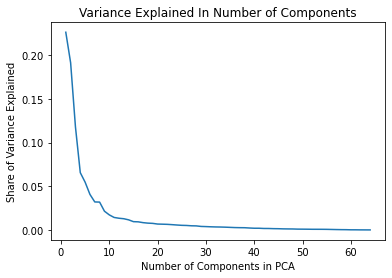

In [46]:
# draw the graph of teh result
x = np.arange(1,len(explained_variance)+1)
plt.plot(x, explained_variance)
plt.title('Variance Explained In Number of Components')
plt.xlabel('Number of Components in PCA')
plt.ylabel('Share of Variance Explained')
plt.show()

In [47]:
# view the results
for i in range(0, 20):
    print(f"Component {i:>2} accounts for {explained_variance[i]*100:>2.2f}% of variance")

Component  0 accounts for 22.65% of variance
Component  1 accounts for 19.15% of variance
Component  2 accounts for 11.80% of variance
Component  3 accounts for 6.56% of variance
Component  4 accounts for 5.47% of variance
Component  5 accounts for 4.07% of variance
Component  6 accounts for 3.21% of variance
Component  7 accounts for 3.19% of variance
Component  8 accounts for 2.15% of variance
Component  9 accounts for 1.72% of variance
Component 10 accounts for 1.43% of variance
Component 11 accounts for 1.34% of variance
Component 12 accounts for 1.28% of variance
Component 13 accounts for 1.16% of variance
Component 14 accounts for 0.95% of variance
Component 15 accounts for 0.93% of variance
Component 16 accounts for 0.83% of variance
Component 17 accounts for 0.78% of variance
Component 18 accounts for 0.75% of variance
Component 19 accounts for 0.67% of variance


In [48]:
# chose the one above which larger than 1%
keep_n_components = 13

# start the final pca
pca = PCA(n_components=keep_n_components, whiten=True)
X_train = pca.fit_transform(combine)

# print the results
for i in range(0, keep_n_components):
    print(f"Component {i:>2} accounts for {pca.explained_variance_ratio_[i]*100:>2.2f}% of variance")

print(len(X_train))
print(combine.shape[0])

print(len(X_train[0])) 

Component  0 accounts for 22.65% of variance
Component  1 accounts for 19.15% of variance
Component  2 accounts for 11.80% of variance
Component  3 accounts for 6.56% of variance
Component  4 accounts for 5.47% of variance
Component  5 accounts for 4.07% of variance
Component  6 accounts for 3.21% of variance
Component  7 accounts for 3.19% of variance
Component  8 accounts for 2.15% of variance
Component  9 accounts for 1.72% of variance
Component 10 accounts for 1.43% of variance
Component 11 accounts for 1.34% of variance
Component 12 accounts for 1.28% of variance
4833
4833
13


In [49]:
# add to the data before the PCA
for x in [X_train]:
    new_columns = []
    
    for i in range(0,keep_n_components):
        new_columns.append([])

    for i in x:
        for j in range(0,keep_n_components):
            new_columns[j].append(i[j])

    for i in range(0,keep_n_components):
        combine[f"Component {i+1}"] = new_columns[i]

In [50]:
# extract all the Components we need
eed_comp = combine.loc[:,'Component 1':f"Component {keep_n_components}"].copy()

In [51]:
# rest index for the further merge
eed_comp = eed_comp.reset_index()
eed_comp.head(3)

LSOA11CD  Component 1  Component 2  Component 3  Component 4  Component 5  \
0  E01000001     2.408210    -0.194670     0.140780     0.387153     0.877996   
1  E01000002     2.748389    -0.049456    -0.054374    -0.080622     0.211890   
2  E01000003     1.074093     0.045465    -0.632608     0.730042    -0.785757   

   Component 6  Component 7  Component 8  Component 9  Component 10  \
0     1.399092    -1.116922    -1.522079    -0.864435      0.488606   
1     2.433086    -0.720954    -0.609122    -0.852842     -0.438257   
2     2.759398    -2.359847    -1.771455     0.821550      1.247685   

   Component 11  Component 12  Component 13  
0      0.471201      0.731269     -0.556078  
1     -0.545365      0.303827     -0.296754  
2      1.679241     -0.068338      0.094494

# Final Process

#### Final Rescaling

In [52]:
# set up the MinMaxScaler
mms = MinMaxScaler(feature_range=(-1,1))

In [53]:
# move the LSOA to the index before the rescale
combine = eed_comp.set_index('LSOA11CD')

In [54]:
# rescale the columns using the MinMaxScaler
for c in combine.columns:
    combine[c] = mms.fit_transform(combine[c].values.reshape(-1,1))

#### K-Means Clustering

........
Largest silhouette score was 0.1368 for k=2


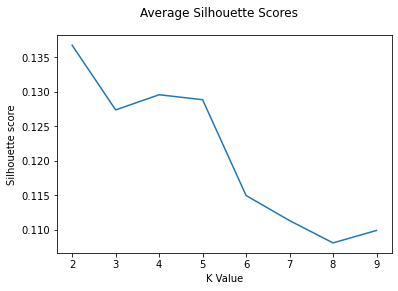

In [55]:
# Adapted from: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.metrics import silhouette_samples, silhouette_score

x = []
y = []

for k in range(2,10):
    
    #############
    # Do the clustering using the main columns
    kmeans = KMeans(n_clusters=k).fit(combine)
    
    # Calculate the overall silhouette score
    silhouette_avg = silhouette_score(combine, kmeans.labels_)
    
    y.append(k)
    x.append(silhouette_avg)
    
    print('.', end='')

print()
print(f"Largest silhouette score was {max(x):6.4f} for k={y[x.index(max(x))]}")

plt.plot(y, x)
plt.xlabel('K Value')
plt.ylabel('Silhouette score')
plt.gcf().suptitle("Average Silhouette Scores");

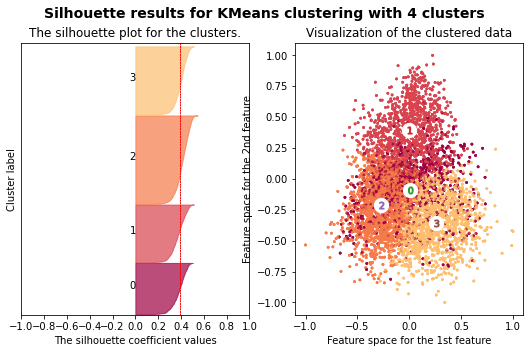

In [56]:
k_pref=4
    
#############
# Do the clustering using the main columns
kmeans = KMeans(n_clusters=k_pref).fit(combine)

# Convert to a series
s = pd.Series(kmeans.labels_, index=combine.index, name='K_Means')

# We do this for plotting
combine['K_Means'] = s
    
# Calculate the overall silhouette score
silhouette_avg = silhouette_score(combine, kmeans.labels_)

# Calculate the silhouette values
sample_silhouette_values = silhouette_samples(combine, kmeans.labels_)
    
#############
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(9, 5)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-1.0, 1.0]) # Changed from -0.1, 1
    
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, combine.shape[0] + (k + 1) * 10])
    
y_lower = 10
    
# For each of the clusters...
for i in range(k_pref):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[kmeans.labels_ == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
        
    # Set the color ramp
    color = plt.cm.Spectral(i/k)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                        0, ith_cluster_silhouette_values,
                        facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=0.5)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks(np.arange(-1.0, 1.1, 0.2)) # Was: [-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]

    # 2nd Plot showing the actual clusters formed --
    # we can only do this for the first two dimensions
    # so we may not see fully what is causing the 
    # resulting assignment
    colors = plt.cm.Spectral(kmeans.labels_.astype(float) / k)
    ax2.scatter(combine[combine.columns[0]], combine[combine.columns[1]], 
                marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("Visualization of the clustered data")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette results for KMeans clustering "
                "with %d clusters" % k_pref),
                fontsize=14, fontweight='bold')

plt.show()

In [57]:
# load the London LSOA shp file
london_lsoa = gpd.read_file('Map/LSOA_2011_London_gen_MHW.shp')

In [58]:
# merge the shp file and the 
clustering_map = pd.merge(combine,london_lsoa,how = 'left', on = 'LSOA11CD')

In [59]:
check_data = pd.merge(df_grocery,losa_info,how='left',on='LSOA11CD')

In [60]:
check_data

LSOA11CD      weight      volume       fat  saturate      salt  \
0     E01000001  308.119047   97.218600  8.535149  3.498749  0.529092   
1     E01000002  313.517874   88.262314  8.054729  3.159077  0.520153   
2     E01000003  315.084751  102.240558  8.153757  3.375788  0.486434   
3     E01000005  356.033437  113.968805  8.339058  3.319496  0.561716   
4     E01000006  451.262063  133.322097  9.622101  3.864007  0.558866   
...         ...         ...         ...       ...       ...       ...   
4828  E01033742  387.401492  100.481483  9.106771  3.576905  0.604229   
4829  E01033743  420.188421  106.949648  9.260919  3.563297  0.536441   
4830  E01033744  402.531751  113.476785  8.888079  3.417265  0.613139   
4831  E01033745  435.686457  120.670999  9.157676  3.453758  0.592790   
4832  E01033746  405.313977  107.150549  8.620603  3.358736  0.648089   

          sugar   protein       carb     fibre  ...  \
0      9.213734  5.262429  15.158014  1.622653  ...   
1      8.337412  5.351774  14.358466  1.692822  ...   
2      9.414937  5.029519  15.820254  1.522523  ...   
3      9.603258  5.230254  17.126487  1.612862  ...   
4     11.355115  5.026295  19.903063  1.640227  ...   
...         ...       ...        ...       ...  ...   
4828   9.149620  5.384490  17.065225  1.551666  ...   
4829  10.940879  4.937452  19.474750  1.504327  ...   
4830  10.220282  5.309611  19.164089  1.524306  ...   
4831  10.230521  5.160060  19.682040  1.598945  ...   
4832   8.968062  5.582404  17.477537  1.600838  ...   

      Qualifications - Other - 2011  \
0                                67   
1                                31   
2                                71   
3                                94   
4                               181   
...                             ...   
4828                            116   
4829                            160   
4830                            142   
4831                            124   
4832                             66   

      Qualifications - Schoolchildren and full-time students: Age 18 and over - 2011  \
0                                                    48                                
1                                                    49                                
2                                                    97                                
3                                                    66                                
4                                                   135                                
...                                                 ...                                
4828                                                 74                                
4829                                                147                                
4830                                                107                                
4831                                                111                                
4832                                                 51                                

      Health - Day-to-day activities limited a lot - 2011  \
0                                                    48     
1                                                    44     
2                                                   112     
3                                                    95     
4                                                    88     
...                                                 ...     
4828                                                 38     
4829                                                 97     
4830                                                219     
4831                                                 84     
4832                                                131     

      Health - Day-to-day activities limited a little - 2011  \
0                                                   115        
1                                                   101        
2                 

In [61]:
# add clustering labels
check_data['Cluster Labels'] = kmeans.labels_

In [62]:
# add clustering labels
clustering_map['Cluster Labels'] = kmeans.labels_
clustering_map['Subregion'] = check_data['Subregion']

Text(0.5, 1.0, 'Subregion Indicate Map')

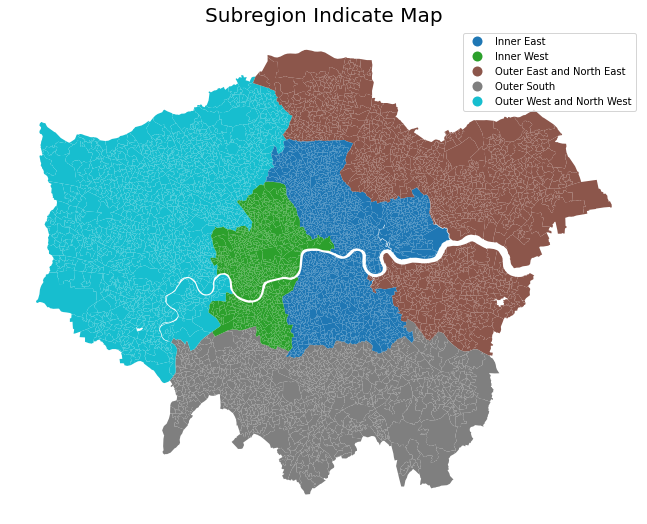

In [63]:
clustering_map = GeoDataFrame(clustering_map)

# set color map
cmap = plt.cm.seismic

# draw the reslut of clustering map
hap='Subregion'
fig,ax=plt.subplots(1,figsize=(15,9))
clustering_map.plot(column=hap,ax=ax,categorical=True,legend=True)
ax.axis('off')
plt.title(f"Subregion Indicate Map",{'fontsize': '20',
 'fontweight' :'100'})

Text(0.5, 1.0, 'K_Means Result (k=4)')

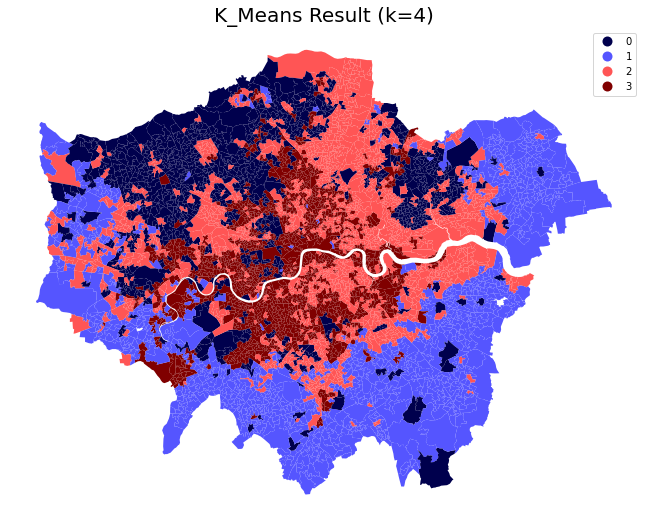

In [64]:
clustering_map = GeoDataFrame(clustering_map)

# set color map
cmap = plt.cm.seismic

# draw the reslut of clustering map
hap='Cluster Labels'
fig,ax=plt.subplots(1,figsize=(15,9))
clustering_map.plot(column=hap,cmap=cmap,ax=ax,categorical=True,legend=True)
ax.axis('off')
plt.title(f"K_Means Result (k=4)",{'fontsize': '20',
 'fontweight' :'100'})

Processing cluster 0
Processing cluster 1
Processing cluster 2
Processing cluster 3


Text(0.5, 0.98, 'Each Clusters Performance in Centroids')

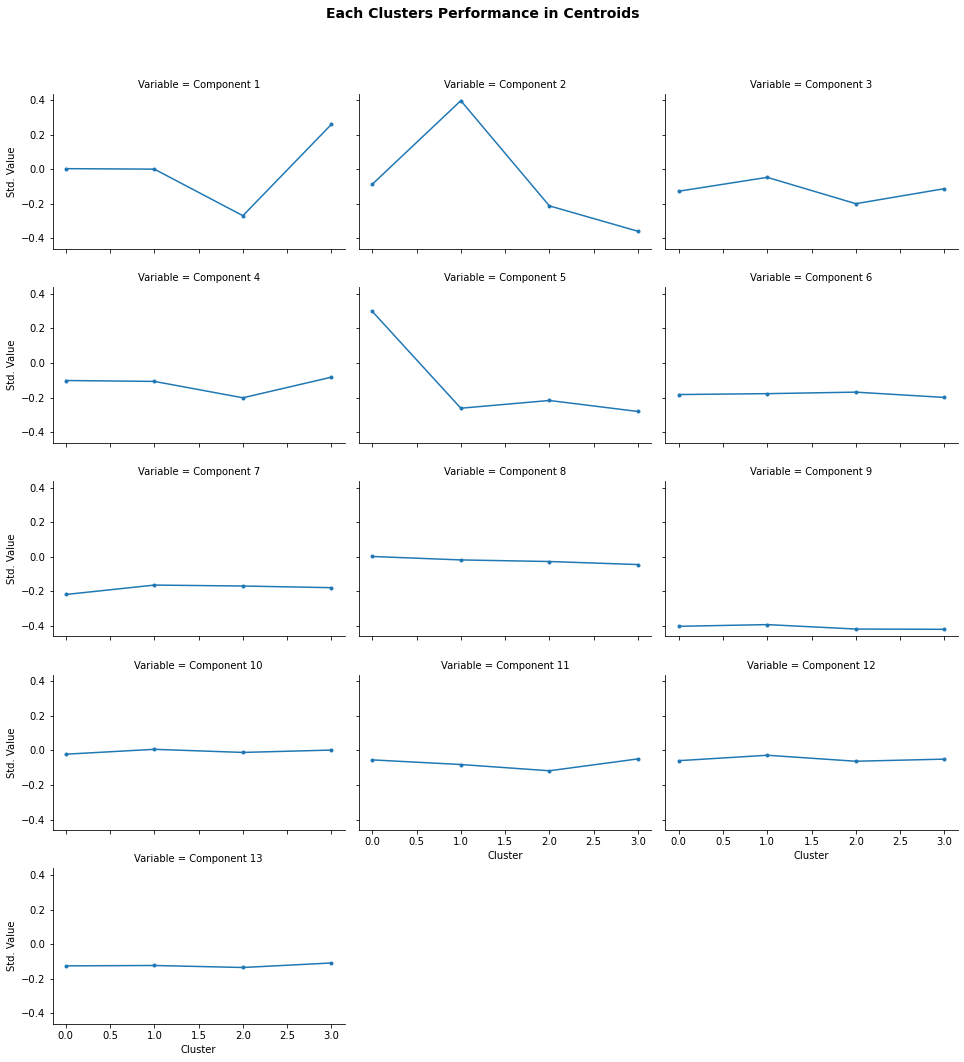

In [65]:
centroids = None
for k in sorted(combine['K_Means'].unique()):
    print(f"Processing cluster {k}")

    c = combine[combine['K_Means']==k]
    if centroids is None:
        centroids = pd.DataFrame(columns=c.columns.values)
    centroids = centroids.append(c.mean(), ignore_index=True)
    
odf = pd.DataFrame(columns=['Variable','Cluster','Std. Value'])
for i in range(0,len(centroids.index)):
    row = centroids.iloc[i,:]
    c_index = list(centroids.columns.values).index('K_Means')
    for c in range(0,c_index):
        d = {'Variable':centroids.columns[c], 'Cluster':row[c_index], 'Std. Value':row[c]}
        odf = odf.append(d, ignore_index=True)
        
odf = odf[~odf.Variable.isin(['LSOA11CD','geometry'])]
g = sns.FacetGrid(odf, col="Variable", col_wrap=3, height=3, aspect=1.5, margin_titles=True, sharey=True)
g = g.map(plt.plot, "Cluster", "Std. Value", marker=".")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(('Each Clusters Performance in Centroids'),fontsize=14, fontweight='bold')

In [66]:
combine

Component 1  Component 2  Component 3  Component 4  Component 5  \
LSOA11CD                                                                     
E01000001     0.683483    -0.160378    -0.099885    -0.037940     0.118396   
E01000002     0.783045    -0.110195    -0.141140    -0.149998    -0.080195   
E01000003     0.293020    -0.077392    -0.263377     0.044200    -0.377631   
E01000005     0.165177     0.160011    -0.923430    -0.035034    -0.281764   
E01000006    -0.149768    -0.120574    -0.155610     0.114084     0.287299   
...                ...          ...          ...          ...          ...   
E01033742     0.250543    -0.362548    -0.460872     0.011045    -0.505014   
E01033743    -0.192630    -0.336137    -0.102994     0.218720    -0.299486   
E01033744    -0.314460    -0.273816    -0.181549    -0.273203    -0.368781   
E01033745    -0.114914    -0.223917    -0.183347    -0.048521    -0.127481   
E01033746     0.280246    -0.224051    -0.385105    -0.459916    -0.292725   

           Component 6  Component 7  Component 8  Component 9  Component 10  \
LSOA11CD                                                                      
E01000001     0.029683    -0.364524    -0.283939    -0.569067      0.082093   
E01000002     0.185372    -0.299193    -0.128405    -0.566936     -0.085175   
E01000003     0.234506    -0.569593    -0.326424    -0.259110      0.219081   
E01000005     0.008452    -0.220303    -0.168391    -0.214805      0.186250   
E01000006    -0.427983    -0.161579     0.119442    -0.530832     -0.032746   
...                ...          ...          ...          ...           ...   
E01033742    -0.420874    -0.287107     0.213550    -0.467143      0.228807   
E01033743    -0.292429    -0.319855     0.271343    -0.725358     -0.015131   
E01033744    -0.192103    -0.232474     0.068831    -0.507733     -0.011908   
E01033745    -0.386428    -0.068320     0.301084    -0.692142      0.139444   
E01033746    -0.148414    -0.204941    -0.180407    -0.768520     -0.151213   

           Component 11  Component 12  Component 13  K_Means  
LSOA11CD                                                      
E01000001     -0.001094      0.053548     -0.206103        3  
E01000002     -0.171326     -0.007698     -0.167820        3  
E01000003      0.201202     -0.061023     -0.110061        3  
E01000005      0.099677     -0.085873     -0.200052        1  
E01000006     -0.034770      0.083719     -0.089024        0  
...                 ...           ...           ...      ...  
E01033742     -0.082241     -0.110329     -0.165830        3  
E01033743     -0.509752     -0.234873     -0.262317        2  
E01033744     -0.054453     -0.031040     -0.181063        2  
E01033745     -0.404495     -0.184490     -0.329566        2  
E01033746      0.179625     -0.088877      0.046844        3  

[4833 rows x 14 columns]

# Exam the Clusters

In [67]:
# extract cluster Labels = 0
group0 = check_data.loc[check_data['Cluster Labels'] == 0,
                     check_data.columns[[0] + list(range(1, check_data.shape[1]))]]

In [68]:
# extract cluster Labels = 1
group1 = check_data.loc[check_data['Cluster Labels'] == 1,
                     check_data.columns[[0] + list(range(1, check_data.shape[1]))]]

In [69]:
# extract cluster Labels = 2
group2 = check_data.loc[check_data['Cluster Labels'] == 2,
                     check_data.columns[[0] + list(range(1, check_data.shape[1]))]]

In [70]:
# extract cluster Labels = 3
group3 = check_data.loc[check_data['Cluster Labels'] == 3,
                     check_data.columns[[0] + list(range(1, check_data.shape[1]))]]

#### View Nutrition

In [71]:
# average nutrition for group 0
group0[['weight','volume','fat','saturate','salt','sugar','protein','carb','fibre','alcohol']].agg('mean').reset_index()

index           0
0    weight  406.950880
1    volume  123.151114
2       fat    9.052114
3  saturate    3.635899
4      salt    0.553199
5     sugar   10.322335
6   protein    5.036043
7      carb   18.221640
8     fibre    1.636289
9   alcohol    0.205633

In [72]:
# average nutrition for group 1
group1[['weight','volume','fat','saturate','salt','sugar','protein','carb','fibre','alcohol']].agg('mean').reset_index()

index           0
0    weight  315.713733
1    volume  100.325847
2       fat    9.325066
3  saturate    3.601175
4      salt    0.573182
5     sugar   11.542765
6   protein    5.284858
7      carb   19.934820
8     fibre    1.688471
9   alcohol    0.224577

In [73]:
# average nutrition for group 2
group2[['weight','volume','fat','saturate','salt','sugar','protein','carb','fibre','alcohol']].agg('mean').reset_index()

index           0
0    weight  400.368400
1    volume  115.365426
2       fat    9.008184
3  saturate    3.505493
4      salt    0.596428
5     sugar   10.263276
6   protein    5.269307
7      carb   18.739936
8     fibre    1.575903
9   alcohol    0.216836

In [74]:
# average nutrition for group 3
group3[['weight','volume','fat','saturate','salt','sugar','protein','carb','fibre','alcohol']].agg('mean').reset_index()

index           0
0    weight  354.947473
1    volume   99.853530
2       fat    8.870247
3  saturate    3.473302
4      salt    0.580877
5     sugar    9.348587
6   protein    5.404925
7      carb   16.736887
8     fibre    1.650503
9   alcohol    0.282922

#### View Health

In [75]:
group0[['Health - Very good or Good health - 2011','Health - Fair health - 2011','Health - Bad or Very Bad health - 2011']].agg('mean').reset_index()

index            0
0  Health - Very good or Good health - 2011  1433.749196
1               Health - Fair health - 2011   191.939979
2    Health - Bad or Very Bad health - 2011    76.368703

In [76]:
group1[['Health - Very good or Good health - 2011','Health - Fair health - 2011','Health - Bad or Very Bad health - 2011']].agg('mean').reset_index()

index            0
0  Health - Very good or Good health - 2011  1309.293613
1               Health - Fair health - 2011   188.094376
2    Health - Bad or Very Bad health - 2011    69.725453

In [77]:
group2[['Health - Very good or Good health - 2011','Health - Fair health - 2011','Health - Bad or Very Bad health - 2011']].agg('mean').reset_index()

index            0
0  Health - Very good or Good health - 2011  1442.477909
1               Health - Fair health - 2011   221.084630
2    Health - Bad or Very Bad health - 2011   111.773491

In [78]:
group3[['Health - Very good or Good health - 2011','Health - Fair health - 2011','Health - Bad or Very Bad health - 2011']].agg('mean').reset_index()

index            0
0  Health - Very good or Good health - 2011  1464.536977
1               Health - Fair health - 2011   147.139871
2    Health - Bad or Very Bad health - 2011    65.395498

#### View Econ Condition

In [79]:
group0['Unemployment_rate'] = group0['Economic Activity - Economically active: Unemployed - 2011']/group0['Economic Activity - Economically active: Total - 2011']
group0[['Economic Activity - Economically active: Total - 2011','Economic Activity - Economically active: Unemployed - 2011','Unemployment_rate','Income, 2011/12 - Median Annual Household Income estimate']].agg('mean').reset_index()

index             0
0  Economic Activity - Economically active: Total...    866.336549
1  Economic Activity - Economically active: Unemp...     55.239014
2                                  Unemployment_rate      0.063573
3  Income, 2011/12 - Median Annual Household Inco...  39120.775608

In [80]:
group1['Unemployment_rate'] = group1['Economic Activity - Economically active: Unemployed - 2011']/group1['Economic Activity - Economically active: Total - 2011']
group1[['Economic Activity - Economically active: Total - 2011','Economic Activity - Economically active: Unemployed - 2011','Unemployment_rate','Income, 2011/12 - Median Annual Household Income estimate']].agg('mean').reset_index()

index             0
0  Economic Activity - Economically active: Total...    823.401335
1  Economic Activity - Economically active: Unemp...     46.197331
2                                  Unemployment_rate      0.056811
3  Income, 2011/12 - Median Annual Household Inco...  36130.620581

In [81]:
group2['Unemployment_rate'] = group2['Economic Activity - Economically active: Unemployed - 2011']/group2['Economic Activity - Economically active: Total - 2011']
group2[['Economic Activity - Economically active: Total - 2011','Economic Activity - Economically active: Unemployed - 2011','Unemployment_rate','Income, 2011/12 - Median Annual Household Income estimate']].agg('mean').reset_index()

index             0
0  Economic Activity - Economically active: Total...    876.296826
1  Economic Activity - Economically active: Unemp...     91.973864
2                                  Unemployment_rate      0.107267
3  Income, 2011/12 - Median Annual Household Inco...  26776.410840

In [82]:
group3['Unemployment_rate'] = group3['Economic Activity - Economically active: Unemployed - 2011']/group3['Economic Activity - Economically active: Total - 2011']
group3[['Economic Activity - Economically active: Total - 2011','Economic Activity - Economically active: Unemployed - 2011','Unemployment_rate','Income, 2011/12 - Median Annual Household Income estimate']].agg('mean').reset_index()

index             0
0  Economic Activity - Economically active: Total...   1047.000000
1  Economic Activity - Economically active: Unemp...     56.776527
2                                  Unemployment_rate      0.054520
3  Income, 2011/12 - Median Annual Household Inco...  44515.625142

#### View Education

In [83]:
group0[['Qualifications - No - 2011','Qualifications - Level 4 and above - 2011']].agg('mean').reset_index()

index           0
0                 Qualifications - No - 2011  223.602358
1  Qualifications - Level 4 and above - 2011  513.365488

In [84]:
group1[['Qualifications - No - 2011','Qualifications - Level 4 and above - 2011']].agg('mean').reset_index()

index           0
0                 Qualifications - No - 2011  251.547188
1  Qualifications - Level 4 and above - 2011  361.406101

In [85]:
group2[['Qualifications - No - 2011','Qualifications - Level 4 and above - 2011']].agg('mean').reset_index()

index           0
0                 Qualifications - No - 2011  309.447418
1  Qualifications - Level 4 and above - 2011  397.764157

In [86]:
group3[['Qualifications - No - 2011','Qualifications - Level 4 and above - 2011']].agg('mean').reset_index()

index           0
0                 Qualifications - No - 2011  146.575563
1  Qualifications - Level 4 and above - 2011  781.576367

#### View Products

In [87]:
products = [x for x in group0.columns.get_level_values(0) if (
    x.startswith("f_"))]
print(products)

['f_beer', 'f_dairy', 'f_eggs', 'f_fats_oils', 'f_fish', 'f_fruit_veg', 'f_grains', 'f_meat_red', 'f_poultry', 'f_readymade', 'f_sauces', 'f_soft_drinks', 'f_spirits', 'f_sweets', 'f_tea_coffee', 'f_water', 'f_wine']


In [88]:
group0[products].agg('mean').sort_values(ascending = False).reset_index()#.head(10)

index         0
0     f_fruit_veg  0.293656
1        f_sweets  0.162523
2        f_grains  0.146601
3         f_dairy  0.113796
4     f_readymade  0.051625
5      f_meat_red  0.041868
6     f_fats_oils  0.032796
7         f_water  0.031764
8   f_soft_drinks  0.028179
9          f_fish  0.020499
10      f_poultry  0.017941
11       f_sauces  0.013657
12         f_wine  0.013436
13         f_eggs  0.011943
14         f_beer  0.010628
15   f_tea_coffee  0.005978
16      f_spirits  0.003110

In [89]:
group1[products].agg('mean').sort_values(ascending = False).reset_index()

index         0
0     f_fruit_veg  0.242741
1        f_sweets  0.187669
2        f_grains  0.171637
3         f_dairy  0.091662
4     f_readymade  0.087152
5      f_meat_red  0.040866
6   f_soft_drinks  0.035069
7         f_water  0.029790
8     f_fats_oils  0.020668
9       f_poultry  0.017975
10         f_fish  0.015864
11         f_beer  0.014863
12         f_wine  0.014857
13       f_sauces  0.012071
14         f_eggs  0.007731
15   f_tea_coffee  0.006099
16      f_spirits  0.003286

In [90]:
group2[products].agg('mean').sort_values(ascending = False).reset_index()

index         0
0     f_fruit_veg  0.261349
1        f_sweets  0.164501
2        f_grains  0.153691
3         f_dairy  0.103584
4     f_readymade  0.058049
5      f_meat_red  0.051750
6         f_water  0.036615
7   f_soft_drinks  0.034485
8     f_fats_oils  0.031070
9          f_fish  0.021697
10      f_poultry  0.020954
11       f_sauces  0.015104
12         f_beer  0.012720
13         f_wine  0.012524
14         f_eggs  0.011775
15   f_tea_coffee  0.006403
16      f_spirits  0.003728

In [91]:
group3[products].agg('mean').sort_values(ascending = False).reset_index()

index         0
0     f_fruit_veg  0.307470
1        f_sweets  0.141599
2        f_grains  0.136791
3         f_dairy  0.106577
4     f_readymade  0.057402
5      f_meat_red  0.049309
6     f_fats_oils  0.028813
7         f_water  0.026859
8   f_soft_drinks  0.024776
9          f_fish  0.024560
10         f_wine  0.022517
11      f_poultry  0.020660
12         f_beer  0.017166
13       f_sauces  0.014579
14         f_eggs  0.012186
15   f_tea_coffee  0.005598
16      f_spirits  0.003137

# Correlation

#### Normalize

In [92]:
reg_data = check_data[['Economic Activity - Economically active: Total - 2011','Economic Activity - Economically active: Unemployed - 2011','fat','sugar','saturate','carb','protein','f_fruit_veg','f_readymade']]

In [93]:
reg_data['unemployment_rate'] = reg_data['Economic Activity - Economically active: Unemployed - 2011']/reg_data['Economic Activity - Economically active: Total - 2011']

<ipython-input-93-d0f81b8ec7c7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['unemployment_rate'] = reg_data['Economic Activity - Economically active: Unemployed - 2011']/reg_data['Economic Activity - Economically active: Total - 2011']


In [94]:
reg_data = reg_data.drop(columns=['Economic Activity - Economically active: Total - 2011','Economic Activity - Economically active: Unemployed - 2011'])

In [95]:
reg_unem = reg_data['unemployment_rate']

In [96]:
# normalize 
reg_data['log_unemployment_rate'] = np.log(reg_data['unemployment_rate'])
reg_data['log_fat'] = np.log(reg_data['fat'])
reg_data['log_sugar'] = np.log(reg_data['sugar'])
reg_data['log_carb'] = np.log(reg_data['carb'])
reg_data['log_protein'] = np.log(reg_data['protein'])
reg_data['log_saturate'] = np.log(reg_data['saturate'])
reg_data['log_fruit_veg'] = np.log(reg_data['f_fruit_veg'])
reg_data['log_readymade'] = np.log(reg_data['f_readymade'])

In [97]:
reg_data = reg_data.drop(columns=['unemployment_rate','fat','sugar','saturate','carb','protein','f_fruit_veg','f_readymade'])

#### Correlation

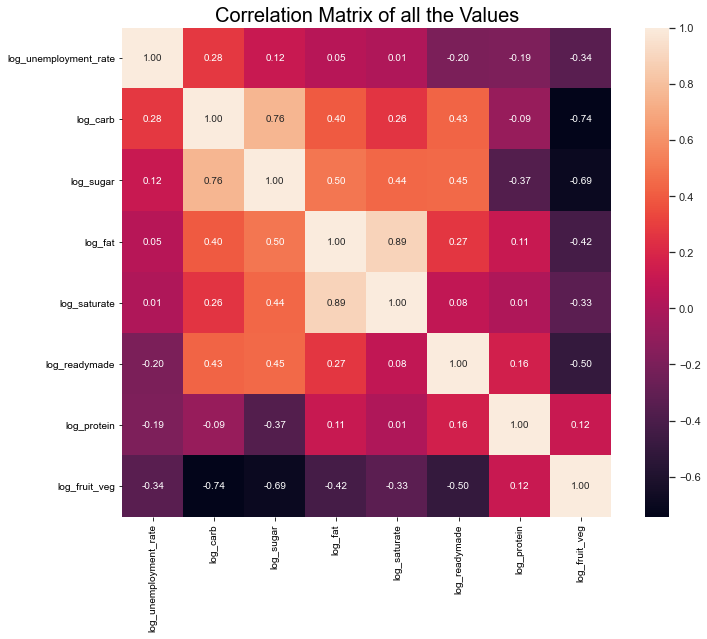

In [98]:
# correlation matrix
corr = reg_data.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 9))

# draw the heat map
k= 10
cols = corr.nlargest(k, 'log_unemployment_rate')['log_unemployment_rate'].index
heat = np.corrcoef(reg_data[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(heat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.title('Correlation Matrix of all the Values',{'fontsize': '20',
 'fontweight' :'100'})
plt.show()

In [99]:
reg_products = check_data[products]

In [100]:
reg_products['unemployment_rate'] = reg_unem

<ipython-input-100-b4073c017d5a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_products['unemployment_rate'] = reg_unem


In [101]:
reg_products = np.log(reg_products)

In [102]:
reg_products

f_beer   f_dairy    f_eggs  f_fats_oils    f_fish  f_fruit_veg  \
0    -4.220418 -1.973234 -4.404511    -3.773919 -3.783020    -1.062138   
1    -3.941592 -2.186737 -4.446778    -4.033726 -3.708110    -1.002245   
2    -3.479506 -2.063868 -4.704944    -3.873951 -4.233566    -1.277266   
3    -4.107028 -2.155177 -4.486033    -3.671071 -3.840064    -1.191657   
4    -4.803999 -2.265740 -4.210792    -3.417025 -4.137006    -1.303382   
...        ...       ...       ...          ...       ...          ...   
4828 -3.570111 -2.205169 -4.208870    -3.399558 -3.928869    -1.290435   
4829 -4.102628 -2.273836 -4.373483    -3.461732 -4.066910    -1.359269   
4830 -4.492042 -2.224426 -4.426252    -3.446418 -3.946137    -1.424568   
4831 -4.716784 -2.211052 -4.326586    -3.369104 -3.976772    -1.338404   
4832 -3.947654 -2.310985 -4.483609    -3.384538 -3.410302    -1.263880   

      f_grains  f_meat_red  f_poultry  f_readymade  f_sauces  f_soft_drinks  \
0    -2.229155   -3.108910  -4.326763    -2.809647 -4.850134      -4.168683   
1    -2.264109   -3.160683  -4.029086    -2.754085 -4.625241      -4.013012   
2    -2.086424   -3.001913  -4.348899    -2.582419 -4.961664      -3.752825   
3    -2.010859   -3.048099  -3.936932    -2.833698 -4.286619      -3.693765   
4    -1.965206   -3.095798  -4.003998    -3.000980 -4.371722      -3.234477   
...        ...         ...        ...          ...       ...            ...   
4828 -1.936594   -2.781413  -3.756201    -2.953316 -4.054791      -3.673560   
4829 -1.830409   -3.130817  -3.952642    -2.889876 -4.558908      -3.247826   
4830 -1.840957   -2.793772  -3.756980    -2.796109 -4.217192      -3.273422   
4831 -1.800926   -2.860644  -3.727468    -2.884202 -4.370261      -3.540463   
4832 -1.974076   -2.727080  -3.959393    -2.948384 -3.957359      -3.555014   

      f_spirits  f_sweets  f_tea_coffee   f_water    f_wine  unemployment_rate  
0     -5.879753 -2.016041     -5.336888 -4.012613 -3.359060          -3.344731  
1     -5.780023 -2.128153     -5.305861 -3.734483 -3.202841          -4.058286  
2     -5.618879 -1.908949     -5.436558 -3.741962 -3.070967          -3.048179  
3     -5.908296 -1.868379     -5.288931 -3.557427 -4.084501          -2.444236  
4     -5.924590 -1.640314     -4.985234 -3.251016 -5.239811          -2.354240  
...         ...       ...           ...       ...       ...                ...  
4828  -5.892763 -1.989536     -5.341678 -3.415771 -4.075652          -2.265229  
4829  -5.568360 -1.796685     -5.239226 -3.145021 -4.109928          -2.249184  
4830  -5.290752 -1.812443     -4.909417 -3.424467 -4.439413          -2.156892  
4831  -6.209562 -1.857763     -5.137516 -3.419569 -4.404779          -2.402430  
4832  -5.882360 -1.952065     -4.754468 -3.746069 -3.898194          -3.162457  

[4833 rows x 18 columns]

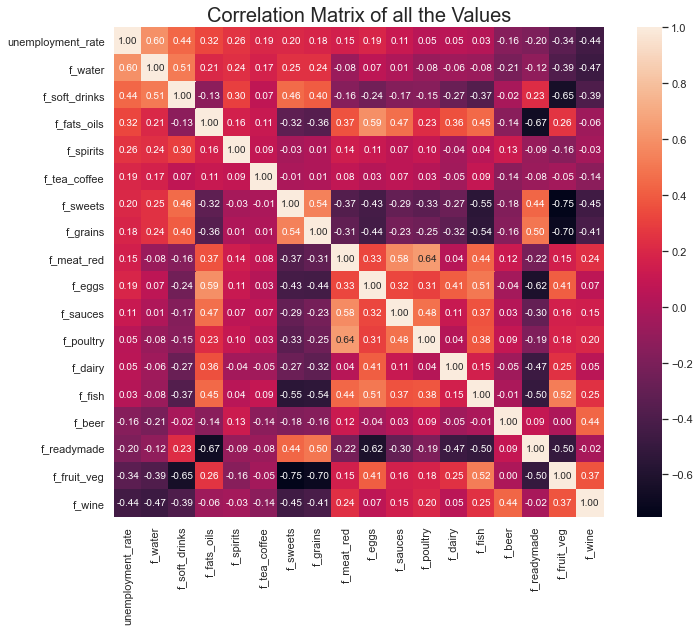

In [103]:
# correlation matrix
corr = reg_products.corr(method='spearman')
f, ax = plt.subplots(figsize=(12, 9))

# draw the heat map
k= 18
cols = corr.nlargest(k, 'unemployment_rate')['unemployment_rate'].index
heat = np.corrcoef(reg_products[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(heat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.title('Correlation Matrix of all the Values',{'fontsize': '20',
 'fontweight' :'100'})
plt.show()

# Anova

In [104]:
# select the group1
un1 = group1[['LSOA11CD','Unemployment_rate','fat','saturate','sugar','protein','carb','f_fruit_veg','f_readymade']]

In [105]:
# select the group2
un2 = group2[['LSOA11CD','Unemployment_rate','fat','saturate','sugar','protein','carb','f_fruit_veg','f_readymade']]

In [106]:
# select the group0
un0 = group0[['LSOA11CD','Unemployment_rate','fat','saturate','sugar','protein','carb','f_fruit_veg','f_readymade']]

In [107]:
# select the group3
un3 = group3[['LSOA11CD','Unemployment_rate','fat','saturate','sugar','protein','carb','f_fruit_veg','f_readymade']]

In [108]:
# Create data point 
x1 = un1['f_readymade']
x2 = un2['f_readymade']
x3 = un3['f_readymade']
x0 = un0['f_readymade']

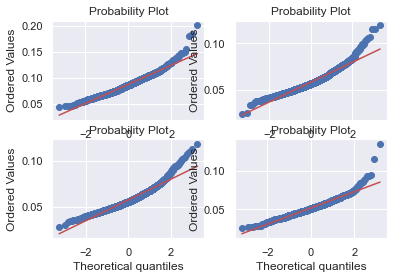

In [109]:
# Quantile-Quantile Plot using SciPy (QQ)
# qq plot is used to check whether the data is distributed normally or not.
import scipy.stats as stats
plt.subplot(221)
stats.probplot(x1, dist="norm", plot=plt)
plt.subplot(222)
stats.probplot(x2, dist="norm", plot=plt)
plt.subplot(223)
stats.probplot(x3, dist="norm", plot=plt)
plt.subplot(224)
stats.probplot(x0, dist="norm", plot=plt)

plt.show()

In [110]:
# Apply Anova
stats.f_oneway(x0,x1,x2,x3)

F_onewayResult(statistic=1550.834670626793, pvalue=0.0)